In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!which python

/home/xju/ocean/venv/langchain_py3p9/bin/python


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
True


## nanoGPT input data

In [30]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [47]:
input_data_dir = "/home/xju/code/nanoGPT/data"
dataset = "trackml"
data_dir = os.path.join(input_data_dir, dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')

In [48]:
train_data.shape

(105997605,)

In [49]:
tokens, counts = np.unique(train_data, return_counts=True)
print(tokens[0], ",", counts[0])

3 , 8186932


In [11]:
block_size = 1024
batch_size = 12
device = "cuda"
device_type = "cuda"

def get_batch(split: str = "train"):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [12]:
X, Y = get_batch('train')

In [14]:
X.shape

torch.Size([12, 1024])

In [15]:
Y.shape

torch.Size([12, 1024])

In [16]:
X[0]

tensor([47, 52, 58,  ...,  1, 51, 63], device='cuda:0')

In [17]:
Y[0]

tensor([52, 58, 57,  ..., 51, 63,  1], device='cuda:0')

## Prepare Tracking data

In [24]:
EVENT_START_TOKEN = 1
EVENT_END_TOKEN = 2
TRACK_START_TOKEN = 3
TRACK_END_TOKEN = 4
TRACK_HOLE_TOKEN = 5
UNKNOWN_TOKEN = 6
MASK_TOKEN = 7
PAD_TOKEN = 8

block_size = 18 + 2  # maximum number of hits for one track + START + END

In [25]:
import os 
import numpy as np
import pandas as pd

## Reproduce umid_dict the same way as in process_data
input_dir = "/home/xju/ocean/data/TrackML/codalab_data"
detector_path = 'detector.csv'

In [124]:

detector = pd.read_csv(Path(input_dir) / detector_path)

detector_umid = np.stack([detector.volume_id, detector.layer_id, detector.module_id], axis=1)
umid_dict = {}
index = 7
for i in detector_umid:
    umid_dict[tuple(i)] = index
    index += 1

## Inverting the umid_dict
umid_dict_inv = {v: k for k, v in umid_dict.items()}

In [12]:
pixel_moudels = [k for k in umid_dict.keys() if k[0] in [7, 8, 9]]

In [70]:
vocab_size = len(pixel_moudels)
print("# of pixel moduels: ", vocab_size)
print("# of all modules: ", len(umid_dict))

# of pixel moduels:  4004
# of all modules:  18728


In [20]:
from acctrack.io import TrackMLReader

uproot is not installed. AthenaRawRootReader will not be available.


In [26]:
reader = TrackMLReader(Path(input_dir) / "train_all")

total 1850 events in directory: /home/xju/ocean/data/TrackML/codalab_data/train_all
Loading detector...
Detector loaded.


In [127]:
%%time
reader.read(0)

read event 21100
Index(['hit_id', 'x', 'y', 'z', 'volume_id', 'layer_id', 'module_id', 'r',
       'phi', 'particle_id', 'vx', 'vy', 'vz', 'pt', 'weight', 'nhits',
       'is_pixel', 'umid', 'geometry_id'],
      dtype='object')
CPU times: user 11.6 s, sys: 783 ms, total: 12.4 s
Wall time: 12.7 s


True

In [128]:
hits = reader.spacepoints

In [129]:
hits[["hit_id", "umid", "particle_id", "pt", "nhits"]]

,hit_id,umid,particle_id,pt,nhits
0,30821,1719,517921928623697922,0.127634,1
1,30811,1719,517921928623702018,0.124454,1
2,20777,897,252206870549237761,0.141079,1
3,15780,828,265713683701698561,0.324658,12
4,27362,1276,292737549208657922,0.205311,12
...,...,...,...,...,...
104862,90689,11859,306245049539100672,0.499549,11
104863,90876,11910,58548994179072000,0.879969,14
104864,104823,18724,292742565713674240,0.658053,15
104865,104769,18712,292735831204954112,2.888478,15


Prepare the dataset for training the GPT model. First we select particles that leave at least 4 hits.

It will be interesting to study the impact of padding in the performance. Let's start without padding. That means within the same *block*, there might be more than one tracks, where *block* means a sequence of hits. 

In [148]:
def get_tracking_data(reader, num_val_evts: int = 5, 
                      min_truth_hits: int = 4, with_padding: bool = False):
    assert reader.nevts > 5, "not enough events for training and validation"
    all_tracks = []
    for idx in range(reader.nevts - 5):
        reader.read(idx)
        hits = reader.spacepoints[["umid", "particle_id", "nhits"]]
        hits = hits[hits.nhits >= min_truth_hits]
        
        vlid_groups = hits.groupby("particle_id")
        tracks = [[START_TOKEN] + vlid_groups.get_group(vlid).umid.to_list() + [END_TOKEN] 
                  for vlid in vlid_groups.groups.keys()]
        if with_padding:
            all_tracks += [ track + [PAD_TOKEN] * (block_size - len(track)) for track in tracks]
        else:
            all_tracks += tracks

    all_tracks = np.array(all_tracks, dytpe=np.uint16)
    return all_tracks

In [130]:
hits = hits[hits.nhits >= 4]

In [132]:
vlid_groups = hits.groupby("particle_id")

In [144]:
tracks = [[START_TOKEN] + vlid_groups.get_group(vlid).umid.to_list() + [END_TOKEN] for vlid in vlid_groups.groups.keys()]

In [145]:
tracks = [ track + [PAD_TOKEN] * (block_size - len(track)) for track in tracks]

In [146]:
tracks = np.array(tracks)

In [147]:
tracks.shape

(7812, 20)

In [101]:
evtid = 21100
inputdir = "/home/xju/ocean/data/TrackML/codalab_data/train_all"
prefix = os.path.join(inputdir, "event{:09d}".format(evtid))
truth_fname = "{}-truth.csv.gz".format(prefix)
truth = pd.read_csv(truth_fname)

In [105]:
reader.particles.vx[np.isnan(reader.particles.vx)]

Series([], Name: vx, dtype: float64)

In [106]:
truth[truth.particle_id == 824162854994186241]

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
104766,104767,824162854994186241,-132.336,926.486,2955.5,0.004405,0.193506,0.069612,0.0
104771,104772,824162854994186241,-133.180,896.044,2944.5,0.005673,0.194931,0.070554,0.0


In [107]:
particle_fname = "{}-particles.csv.gz".format(prefix)
particles = pd.read_csv(particle_fname)

In [108]:
particles[particles.particle_id == 824162854994186241]

,particle_id,particle_type,vx,vy,vz,px,py,pz,q,nhits
10297,824162854994186241,2212,52.3031,193.04,2653.99,-0.114878,0.148643,0.088223,1,2


In [113]:
aa = truth.merge(particles, on="particle_id", how="left")

In [114]:
aa[aa.particle_id == 824162854994186241]

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_type,vx,vy,vz,px,py,pz,q,nhits
104766,104767,824162854994186241,-132.336,926.486,2955.5,0.004405,0.193506,0.069612,0.0,2212,52.3031,193.04,2653.99,-0.114878,0.148643,0.088223,1,2
104771,104772,824162854994186241,-133.180,896.044,2944.5,0.005673,0.194931,0.070554,0.0,2212,52.3031,193.04,2653.99,-0.114878,0.148643,0.088223,1,2


In [112]:
particles.loc[len(particles.index)] = 0

## Performance

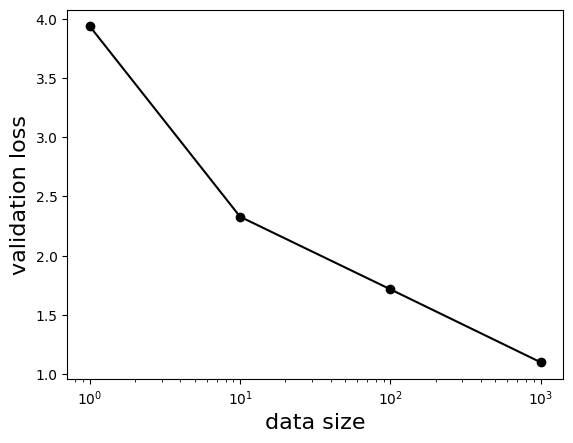

In [50]:
data_size = [1, 10, 100, 1000]
val_loss = [3.9347, 2.3281, 1.7158, 1.1]

fontsize = 16
plt.plot(data_size, val_loss, "k-o",)
plt.xlabel("data size", fontsize=fontsize)
plt.ylabel("validation loss", fontsize=fontsize)
plt.xscale("log")

## Torch Text

In [52]:
# import datasets
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')

def tokenize(label, line):
    return line.split()

tokens = []
for label, line in train_iter:
    tokens += tokenize(label, line)
    break

In [54]:
label, line

(1,
 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwee

In [55]:
tokens

['I',
 'rented',
 'I',
 'AM',
 'CURIOUS-YELLOW',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967.',
 'I',
 'also',
 'heard',
 'that',
 'at',
 'first',
 'it',
 'was',
 'seized',
 'by',
 'U.S.',
 'customs',
 'if',
 'it',
 'ever',
 'tried',
 'to',
 'enter',
 'this',
 'country,',
 'therefore',
 'being',
 'a',
 'fan',
 'of',
 'films',
 'considered',
 '"controversial"',
 'I',
 'really',
 'had',
 'to',
 'see',
 'this',
 'for',
 'myself.<br',
 '/><br',
 '/>The',
 'plot',
 'is',
 'centered',
 'around',
 'a',
 'young',
 'Swedish',
 'drama',
 'student',
 'named',
 'Lena',
 'who',
 'wants',
 'to',
 'learn',
 'everything',
 'she',
 'can',
 'about',
 'life.',
 'In',
 'particular',
 'she',
 'wants',
 'to',
 'focus',
 'her',
 'attentions',
 'to',
 'making',
 'some',
 'sort',
 'of',
 'documentary',
 'on',
 'what',
 'the',
 'average',
 'Swede',
 'thought',
 'about',
 'certai